## This routine processes RSP cloud data for ER2
## for use in Keras FC NN scheme
#---------------------------------------------------------------------
1. Read nc file (per parameter)
2. create Data frame from each parameter of nc
3. normalize each variable (Min-max/scale) from sklearn MinMaxScaler or implicit
4. concat DF according to parameter inputs sets
5. save DF and output as .csv for further processing with Keras NN
6. upload .csv files for NN model processing
7. divide test and train
8. build model
9. compile and fit
10.test model (evaluate)

In [95]:
# import neccesary modules for this module
#-------------------------------------------
import pandas as pd
import numpy as np
import scipy as sio
import scipy.stats as stats
import netCDF4 as nc4
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import shapefile
# keras related libraries
from keras.models import Sequential # import model
from keras.layers import Dense, Dropout, Activation, Flatten, GaussianNoise # import core layers
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.utils import np_utils # import helper funcs
from keras.regularizers import l2 # import l2 regularizer
%matplotlib inline

In [96]:
## read netcdf parameters from LUT or measurements files
## nc_file is full file path, 
## e.g. filepath = '..//..//py_data//oracles_NN//training//NNcld_20150911_20160102_20160420_nonoise.nc'
## varname is netcdf variable name string in file, e.g. "ref_i", "ref_q" or "dolp"
##-------------------------------------------------------------------------------

def read_nc_file( nc_file, varname ):
    f = nc4.Dataset(nc_file)
    data = f.variables[varname]
    #f.close()
    return data;

In [97]:
## cat netcdf parameters from LUT or measurements files
## to create dataframe in pandas, 
## colname is column name to change from default
##-----------------------------------------------------

def create_df_from_nc( nc_data, colname ):
    df = pd.DataFrame([])
    # check data size and length 
    l = len(nc_data.shape)
    vza = np.arange(24,125)
    # if l=3 cat dataframe, if l=1 save var as df
    if   l==3:
        # wavelength dim is the 2nd element
        for i in range(nc_data.shape[1]):
                #df=df.append(pd.DataFrame(nc_data[:,i,:]))
                tmp = pd.DataFrame(np.transpose(nc_data[vza,i,:]))# only VZA -40 to 40
                # rename column name
                tmp.rename(columns=lambda x: colname + '_lambda_' + str(i+1) + '_VZA_',
                               inplace=True)
                df = pd.concat([df, tmp], axis=1)
                
    elif l==2:
            tmp = pd.DataFrame(np.transpose(nc_data[3,:])) # 3 is the VZA index (all rows suppose to be similar)
            df=df.append(pd.DataFrame(tmp))
            # rename column name
            df.rename(columns=lambda x: colname, inplace=True)
    elif l==1:
            df=df.append(pd.DataFrame(nc_data[:]))
            # rename column name
            df.rename(columns=lambda x: colname, inplace=True)
    return df;

In [98]:
## standartize data frame before applying projection
##---------------------------------------------------

def std_df( data_df ):
    
    # extract values only from DF
    data = data_df.iloc[:,:].values
    # standartize
    #if data_df.shape[1]>1:
        #data_std = StandardScaler().fit_transform(data)
    data_std = MinMaxScaler().fit_transform(data)
    #else:
        #data_std = StandardScaler().fit_transform(data.T)
        #data_std = MinMaxScaler().fit_transform(data.T)

    
    # test:
    print('original data: ', data[0:5,0:5])
    print('standartized data: ', data_std[0:5,0:5])
    
    # plot:
    #------
    # this is for DF
    #plt.plot(ref_i.iloc[1,0:151].values)
    
    if data_df.shape[1]>1:
        # orig
        plt.plot(data[10,0:100])# VZA size is 101
        plt.plot(data[10,1*100+1:2*100])
        plt.plot(data[10,2*100+1:3*100])
        plt.plot(data[10,3*100+1:4*100])
        plt.plot(data[10,4*100+1:5*100])
        plt.plot(data[10,5*100+1:6*100])
        plt.plot(data[10,6*100+1:7*100])
        plt.legend(['lambda 1 orig', 'lambda 2 orig','lambda 3 orig', 'lambda 4 orig', 
                    'lambda 5 orig', 'lambda 6 orig', 'lambda 7 orig'], loc='best')
        plt.show()

        # std
        plt.plot(data_std[10,0:100])# VZA size is 101
        plt.plot(data_std[10,1*100+1:2*100])
        plt.plot(data_std[10,2*100+1:3*100])
        plt.plot(data_std[10,3*100+1:4*100])
        plt.plot(data_std[10,4*100+1:5*100])
        plt.plot(data_std[10,5*100+1:6*100])
        plt.plot(data_std[10,6*100+1:7*100])
        plt.legend(['lambda 1 std', 'lambda 2 std','lambda 3 std', 'lambda 4 std', 
                    'lambda 5 std', 'lambda 6 std', 'lambda 7 std'], loc='best')
        plt.show()
        
    else:
        # orig
        plt.plot(np.arange(0, len(data), 1),data,'b.')
        plt.legend('orig')
        plt.show()
        # std
        plt.plot(np.arange(0, len(data), 1),data_std,'b.')
        plt.legend('std')
        plt.show()
    
    
    return pd.DataFrame(data_std, columns=data_df.columns)

In [99]:
# 1. read rsp nc file
#--------------------
filepath = 'D://ORACLES_NN//py_data//ER2_nonoise.nc'
ref_i_ = read_nc_file( nc_file=filepath, varname="ref_i" )
ref_q_ = read_nc_file( nc_file=filepath, varname="ref_q" )
azi_   = read_nc_file( nc_file=filepath, varname="azi" )
sza_   = read_nc_file( nc_file=filepath, varname="sza" )
cod_   = read_nc_file( nc_file=filepath, varname="cod" )
ref_   = read_nc_file( nc_file=filepath, varname="sizea" )
vef_   = read_nc_file( nc_file=filepath, varname="sizeb" )
print("ref_i_shape:",ref_i_.shape)
print("ref_q_shape:",ref_q_.shape)
print("azi_shape:",azi_.shape)
print("sza_shape:",sza_.shape)
print("cod_shape:",cod_.shape)
print("ref_shape:",ref_.shape)
print("vef_shape:",vef_.shape)

ref_i_shape: (152, 7, 44064)
ref_q_shape: (152, 7, 44064)
azi_shape: (44064,)
sza_shape: (44064,)
cod_shape: (44064,)
ref_shape: (44064,)
vef_shape: (44064,)


In [103]:
# 2. create DF
#==============
ref_i = create_df_from_nc( ref_i_, "ref_i" )
ref_q = create_df_from_nc( ref_q_, "ref_q" )
azi   = create_df_from_nc( azi_,   "azi" )
sza   = create_df_from_nc( sza_,   "sza" )
cod   = create_df_from_nc( cod_,   "cod" )
ref   = create_df_from_nc( ref_,   "ref" )
vef   = create_df_from_nc( vef_,   "vef" )

print(azi.shape)
print(azi.size)
print(len(azi.shape))
#print("azi:",len(azi))
#plt.plot(np.arange(0, len(azi), 1),azi.iloc[:,:].values,'b.')
#plt.show()

# replace colnames for division:
ref_q.rename(columns=lambda x: x.replace("ref_q", 'ref_i'),inplace=True)
dolp  = (ref_q / ref_i).abs()

# replace colnames back:
ref_q.rename(columns=lambda x: x.replace("ref_i", 'ref_q'),inplace=True)
dolp.rename(columns=lambda x: x.replace("ref_i", 'dolp'),inplace=True)

# create ref_q_abs frame
ref_q_abs = ref_q.abs()
# renmame columns
ref_q_abs.rename(columns=lambda x: x.replace("ref_q", 'ref_q_abs'),inplace=True)

# concat DF to form various input combinations
#df = pd.concat([df, tmp], axis=1)
print("ref_i_df shape and data: ",ref_i.shape, ref_i.head())
print("ref_q_df shape and data: ",ref_q.shape, ref_q.head())
print("dolp_df shape and data: ", dolp.shape, dolp.head())
print("min azi: " , azi.min(), "max azi: ", azi.max())
print("azi:", np.unique(azi))
print("sza:", np.unique(sza))

(44064, 1)
44064
2
ref_i_df shape and data:  (44064, 707)    ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
0             0.247901             0.243094             0.238727   
1             0.247943             0.243127             0.238745   
2             0.248040             0.243196             0.238774   
3             0.248168             0.243287             0.238808   
4             0.248360             0.243443             0.238907   

   ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
0             0.236313             0.235342             0.234982   
1             0.236319             0.235336             0.234969   
2             0.236314             0.235300             0.234913   
3             0.236294             0.235226             0.234804   
4             0.236312             0.235146             0.234663   

   ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  ref_i_lambda_1_VZA_  \
0             0.235429             0.235546             

original data:  [[ 0.24790095  0.24309392  0.23872684  0.23631333  0.23534183]
 [ 0.24794313  0.2431266   0.23874524  0.23631917  0.23533577]
 [ 0.24803999  0.24319635  0.23877409  0.23631413  0.23529963]
 [ 0.24816781  0.24328701  0.23880784  0.2362942   0.23522583]
 [ 0.24836041  0.24344334  0.23890699  0.23631179  0.2351457 ]]
standartized data:  [[ 0.0676972   0.05984604  0.05493021  0.05082417  0.04773939]
 [ 0.06775612  0.05989212  0.05495679  0.05083263  0.04773062]
 [ 0.06789142  0.05999044  0.05499846  0.05082533  0.04767844]
 [ 0.06806996  0.06011826  0.05504721  0.05079642  0.04757184]
 [ 0.06833899  0.06033862  0.05519044  0.05082193  0.04745612]]


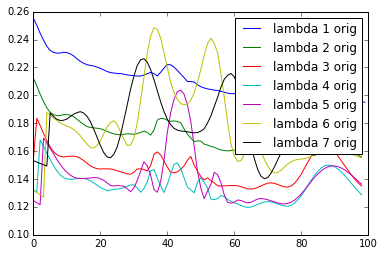

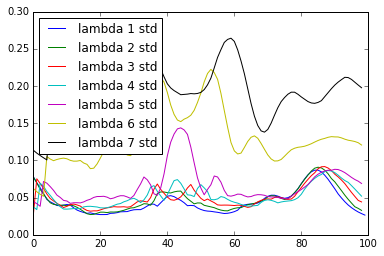

original data:  [[-0.03462248 -0.02498684 -0.01531657 -0.00975835 -0.0072451 ]
 [-0.03474207 -0.02509247 -0.01539576 -0.0098109  -0.00726829]
 [-0.03505209 -0.02536395 -0.01559285 -0.00993614 -0.00731472]
 [-0.03550999 -0.02577794 -0.0159123  -0.01014268 -0.00738357]
 [-0.03615524 -0.02640538 -0.01647081 -0.01053086 -0.00752526]]
standartized data:  [[ 0.61247635  0.53972018  0.77002013  0.79584873  0.78095412]
 [ 0.61169386  0.5391587   0.76946384  0.79547912  0.78079444]
 [ 0.60966545  0.53771579  0.76807946  0.7945981   0.78047466]
 [ 0.60666949  0.53551531  0.76583558  0.7931453   0.78000051]
 [ 0.60244769  0.53218043  0.76191252  0.79041481  0.77902478]]


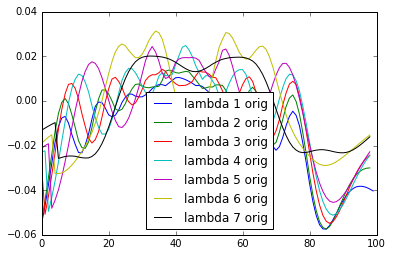

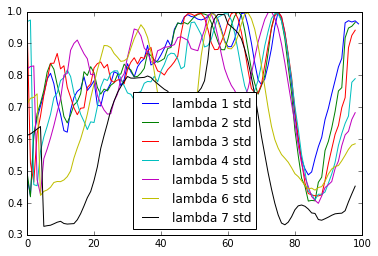

original data:  [[ 0.13966255  0.10278676  0.06415939  0.04129411  0.03078543]
 [ 0.14012113  0.10320742  0.06448616  0.04151545  0.03088475]
 [ 0.14131629  0.10429411  0.06530379  0.04204632  0.03108682]
 [ 0.14308861  0.10595693  0.06663224  0.04292394  0.0313893 ]
 [ 0.14557569  0.10846621  0.06894234  0.04456341  0.03200255]]
standartized data:  [[ 0.34598428  0.25490057  0.15911891  0.1028441   0.07717776]
 [ 0.34712031  0.2559438   0.15992934  0.10339537  0.07742675]
 [ 0.35008109  0.25863871  0.16195713  0.10471753  0.07793336]
 [ 0.35447162  0.26276237  0.16525181  0.10690329  0.07869169]
 [ 0.36063287  0.26898521  0.17098105  0.11098649  0.08022914]]


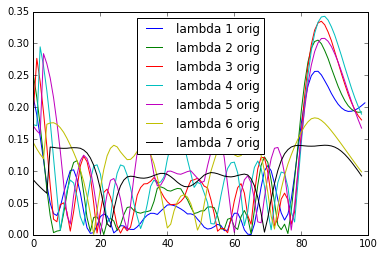

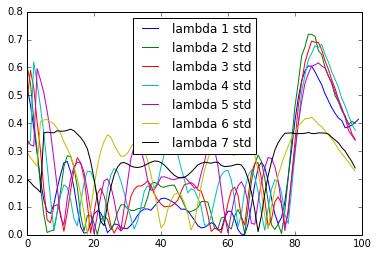

original data:  [[ 0.]
 [ 2.]
 [ 4.]
 [ 6.]
 [ 8.]]
standartized data:  [[ 0.        ]
 [ 0.02222222]
 [ 0.04444445]
 [ 0.06666667]
 [ 0.08888889]]


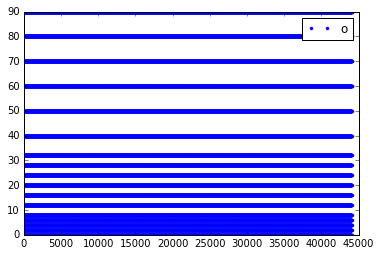

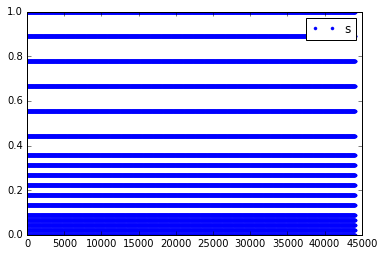

original data:  [[ 10.]
 [ 10.]
 [ 10.]
 [ 10.]
 [ 10.]]
standartized data:  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


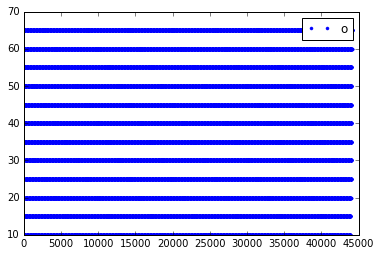

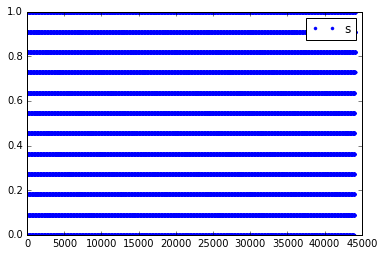

original data:  [[ 2.5]
 [ 2.5]
 [ 2.5]
 [ 2.5]
 [ 2.5]]
standartized data:  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


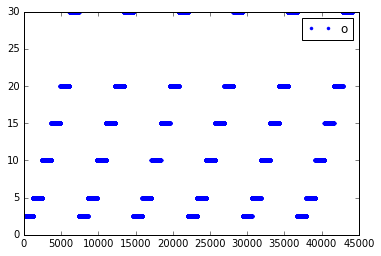

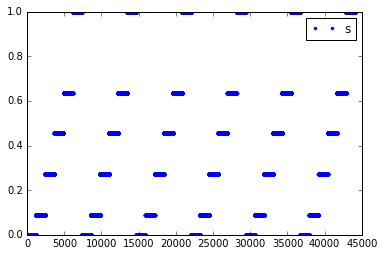

original data:  [[ 5.]
 [ 5.]
 [ 5.]
 [ 5.]
 [ 5.]]
standartized data:  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


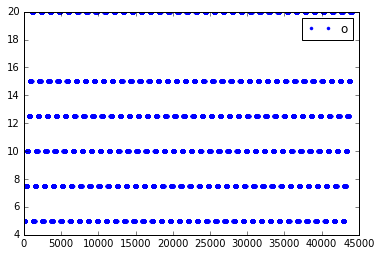

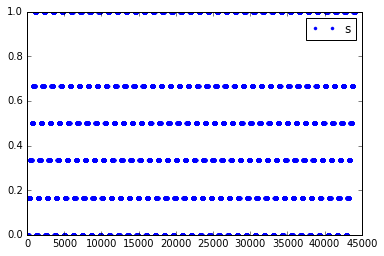

original data:  [[ 0.01]
 [ 0.01]
 [ 0.01]
 [ 0.01]
 [ 0.01]]
standartized data:  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


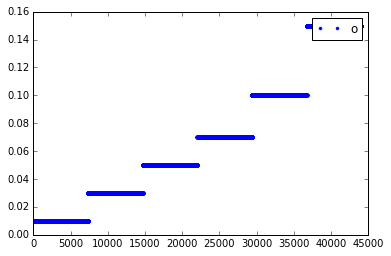

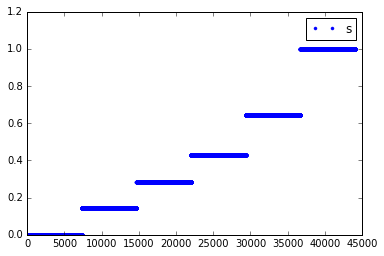

In [10]:
# 3. standartize
#----------------
ref_i_std = std_df( ref_i )
ref_q_std = std_df( ref_q )
dolp_std  = std_df( dolp )
azi_std   = std_df( azi )
sza_std   = std_df( sza )
cod_std   = std_df( cod )
ref_std   = std_df( ref )
vef_std   = std_df( vef )

In [12]:
# 4.+ 5. concat DF and save into csv
#------------------------------------
# out_norm
df_out_norm     = pd.concat([cod_std, ref_std, vef_std], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_y_train_norm.csv'
df_out_norm.to_csv(file_name, header=True, index=False)

# out_orig
df_out     = pd.concat([cod, ref, vef], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_y_train_orig.csv'
df_out.to_csv(file_name, header=True, index=False)

# data
ref_i_ref_q = pd.concat([azi_std, sza_std, ref_i_std, ref_q_std], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_i_ref_q.csv'
ref_i_ref_q.to_csv(file_name, header=True, index=False)


ref_i_dolp = pd.concat([azi_std, sza_std, ref_i_std, dolp_std], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_i_dolp.csv'
ref_i_dolp.to_csv(file_name, header=True, index=False)

ref_q_dolp = pd.concat([azi_std, sza_std, ref_q_std, dolp_std], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_q_dolp.csv'
ref_q_dolp.to_csv(file_name, header=True, index=False)

ref_i_x = pd.concat([azi_std, sza_std, ref_i_std], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_i.csv'
ref_i_x.to_csv(file_name, header=True, index=False)

ref_q_x = pd.concat([azi_std, sza_std, ref_q_std], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_q.csv'
ref_q_x.to_csv(file_name, header=True, index=False)

dolp_x = pd.concat([azi_std, sza_std, dolp_std], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_dolp.csv'
dolp_x.to_csv(file_name, header=True, index=False)

In [84]:
# all inputs together:
ref_i_ref_q_dolp = pd.concat([azi_std, sza_std, ref_i_std, ref_q_std, dolp_std], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_i_ref_q_dolp.csv'
ref_i_ref_q_dolp.to_csv(file_name, header=True, index=False)

In [85]:
# data -orig - no normalization

ref_i_ref_q = pd.concat([azi, sza, ref_i, ref_q], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_i_ref_q_orig.csv'
ref_i_ref_q.to_csv(file_name, header=True, index=False)


ref_i_dolp = pd.concat([azi, sza, ref_i, dolp], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_i_dolp_orig.csv'
ref_i_dolp.to_csv(file_name, header=True, index=False)

ref_q_dolp = pd.concat([azi, sza, ref_q, dolp], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_q_dolp_orig.csv'
ref_q_dolp.to_csv(file_name, header=True, index=False)

ref_i_x = pd.concat([azi, sza, ref_i], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_i_orig.csv'
ref_i_x.to_csv(file_name, header=True, index=False)

ref_q_x = pd.concat([azi, sza, ref_q], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_q_orig.csv'
ref_q_x.to_csv(file_name, header=True, index=False)

dolp_x = pd.concat([azi, sza, dolp], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_dolp_orig.csv'
dolp_x.to_csv(file_name, header=True, index=False)

ref_i_ref_q_dolp = pd.concat([azi, sza, ref_i, ref_q, dolp], axis=1)
file_name = 'D://ORACLES_NN//py_inputs//ER2_x_ref_i_ref_q_dolp_orig.csv'
ref_i_ref_q_dolp.to_csv(file_name, header=True, index=False)

In [73]:
# 6. + 7. split train/test
#---------------------------
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# run different variations
var_in = ["ref_i_ref_q","ref_i_dolp","ref_q_dolp","ref_i","ref_q","dolp"]
var_in = ["ref_i_dolp"]

for f in range(len(var_in)):
    
    # import x
    x_filename = 'D://ORACLES_NN//py_inputs//ER2_x_' + var_in[f] + '.csv'
    X_ = pd.read_csv(x_filename)
    #print(X.head())
    #import y
    y_ = pd.read_csv('D://ORACLES_NN//py_inputs//ER2_y_train_orig.csv')
    
    X = X_.iloc[:,:].values
    y = y_.iloc[:,:].values
    
    #print(y.head())
    # import train/validation data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,shuffle=True)

    # print and plot data samples

    print("X_shape",      X.shape)
    print("X_train_shape",X_train.shape)
    print("X_test_shape" ,X_test.shape)
    print("X_train_shape[0]",X_train.shape[0])
    print("y_train_shape",y_train.shape)
    print("y_test_shape" ,y_test.shape)
    print("y_train_sample",y_train[0:5])


X_shape (44064, 1416)
X_train_shape (30844, 1416)
X_test_shape (13220, 1416)
X_train_shape[0] 30844
y_train_shape (30844, 3)
y_test_shape (13220, 3)
y_train_sample [[  2.50000000e+00   1.00000000e+01   7.00000003e-02]
 [  1.00000000e+01   1.50000000e+01   9.99999978e-03]
 [  1.00000000e+01   2.00000000e+01   1.50000006e-01]
 [  1.50000000e+01   2.00000000e+01   1.00000001e-01]
 [  1.50000000e+01   1.25000000e+01   2.99999993e-02]]


In [74]:
# 8. build model
#-----------------
model = Sequential()

model.add(Dropout(0.50, input_shape=X_train.shape[1:], name="drop_input"))
model.add(Dense(1024, activation='relu', name="fc1"))
model.add(Dropout(0.50, name="drop_fc1"))
model.add(Dense(1024, activation='relu', name="fc2"))
model.add(Dropout(0.50, name="drop_fc2"))
model.add(Dense(1024, activation='relu', name="fc3"))
model.add(Dropout(0.50, name="drop_fc3"))
model.add(Dense(y_test.shape[1], activation='linear',name='out_linear'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
drop_input (Dropout)         (None, 1416)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              1451008   
_________________________________________________________________
drop_fc1 (Dropout)           (None, 1024)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 1024)              1049600   
_________________________________________________________________
drop_fc2 (Dropout)           (None, 1024)              0         
_________________________________________________________________
fc3 (Dense)                  (None, 1024)              1049600   
_________________________________________________________________
drop_fc3 (Dropout)           (None, 1024)              0         
__________

In [76]:
# 8. + 9. compile and fit
#------------------------

# optimizer
adam = Adam(lr=0.0001)
model.compile(loss='mean_squared_error', 
              optimizer=adam,
              metrics=['accuracy'])
# early stopping conditions:
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=0, mode='auto')
# saving best model params
checkpointer = ModelCheckpoint(filepath="D://ORACLES_NN//py_outputs//ER2_model_weights.hdf5", verbose=0, 
                               mode='max', save_best_only=True)
csv_logger  = CSVLogger('D://ORACLES_NN//py_outputs//ER2_model_log.csv', 
                                   append=True, separator=';')
    
#hist = model.fit(..., callbacks=[checkpointer])
#model.load_weights('weights.hdf5')
#predicted = model.predict(X_test_mat)

# using callbacks to stop/save
#callbacks = [
#    EarlyStopping(monitor='val_loss', patience=2, verbose=0),
#    ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
#]

#callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=0, mode='auto')]
#callbacks = [EarlyStopping,checkpointer,csv_logger]

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
#print(X_train.head())
model.fit(x = X_train, y=y_train,
          epochs=2, batch_size=128,verbose=1,validation_split=0.15, 
          callbacks = [earlystopping,checkpointer,csv_logger])


Train on 26217 samples, validate on 4627 samples
Epoch 1/2
26217/26217 [==============================] - 17s - loss: 7.1587 - acc: 0.9089 - val_loss: 21.3317 - val_acc: 0.8751
Epoch 2/2
26217/26217 [==============================] - 16s - loss: 5.9900 - acc: 0.9131 - val_loss: 22.8155 - val_acc: 0.8433


In [77]:
#print("type:",type(X_test))
#print(X_test.iloc[0:5,0:5])
#print("type:",type(np.asarray(X_test)))
#print(np.asarray(X_test[0:5,0:5]))

In [78]:
# 10. model evaluate
#-------------------
score, acc = model.evaluate(X_test, y_test, batch_size=128)
print("score is: ", score, "accuracy is: ", acc)

12928/13220 [============================>.] - ETA: 0sscore is:  22.3162382769 accuracy is:  0.84198184576


## 11. this step is to run all model options

In [152]:
# this function splits train/test sets from data for each of the input variables
#--------------------------------------------------------------------------------
# pre_file is a str describing the path and pre_file name for input csv file to split,
# e.g. 'D://ORACLES_NN//py_inputs//ER2_x_
# var_in is the variable input combination str e.g. "ref_i_dolp"
# var_out is file path and name for the output csv file, 
# e.g.: 'D://ORACLES_NN//py_inputs//ER2_y_train_orig.csv'
#
def split_data(pre_file, var_in, var_out):
    
    from sklearn import preprocessing
    from sklearn.model_selection import train_test_split
    import numpy as np
    
    # import x
    x_filename = pre_file + var_in + '.csv'
    X_ = pd.read_csv(x_filename)
    #print(X.head())
    #import y
    y_ = pd.read_csv(var_out)
    
    X = X_.iloc[:,:].values
    y = y_.iloc[:,:].values
    
    #print(y.head())
    # import train/validation data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,shuffle=True)

    # print and plot data samples

    print("X_shape",      X.shape)
    print("X_train_shape",X_train.shape)
    print("X_test_shape" ,X_test.shape)
    print("X_train_shape[0]",X_train.shape[0])
    print("y_train_shape",y_train.shape)
    print("y_test_shape" ,y_test.shape)
    print("y_train_sample",y_train[0:5])
    
    # convert to keras input type:
    X_train = X_train.astype('float32')
    X_test  = X_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test  = y_test.astype('float32')
    
    
    return X_train, X_test, y_train, y_test

In [160]:
# this function defines the model to run
#----------------------------------------
# input shape is tensor shape (without number of samples), i.e.X_train.shape[1:]
# output shape is tensor shape of the output (without number of samples), i.e. y_test.shape[1]
#

def model(input_shape, output_shape):

    model = Sequential()

    #model.add(Dropout(0.25, input_shape=input_shape, name="drop_input"))
    model.add(GaussianNoise(0.01, input_shape=input_shape))
    #model.add(Dense(4664, activation='relu', name="fc0"))
    model.add(Dense(2832, activation='relu', name="fc1"))
    #model.add(Dropout(0.25, name="drop_fc1"))
    model.add(Dense(2832, activation='relu', name="fc2"))
    #model.add(Dropout(0.25, name="drop_fc2"))
    model.add(Dense(1416, activation='relu', name="fc3"))
    model.add(Dense(1416, activation='relu', name="fc4"))
    model.add(Dense(708, activation='relu', name="fc5"))
    model.add(Dense(708, activation='relu', name="fc6"))
    model.add(Dense(708, activation='relu', name="fc7"))
    model.add(Dense(708, activation='relu', name="fc8"))
    model.add(Dense(354, activation='relu', name="fc9"))
    model.add(Dense(354, activation='relu', name="fc10"))
    model.add(Dense(354, activation='relu', name="fc11"))
    model.add(Dense(354, activation='relu', name="fc12"))
    
    #model.add(Dropout(0.25, name="drop_fc4"))
    model.add(Dense(output_shape, activation='linear',name='out_linear'))

    model.summary()
    
    return model

In [161]:
# this function runs the model (compile, fit, and evaluate on test)
#---------------------------------------------------------------------
# model - is model generated by model function
# lr - learning rate
# decay - optimizer decay rate (regularizer)
# var_in - str with variable combination for saving model run results
# file_str - str to save run files (e.g. ER2 or P3)
# X_train, X_test, y_train, y_test are outputs from split_data()
#

def run_model(model, var_in, file_str, X_train, X_test, y_train, y_test, optimizer = "adam", lr=0.0001, decay=0):
    
    import numpy
    
    # optimizer
    if optimizer == "adam":
        adam = Adam(lr=lr,decay=decay)
        model.compile(loss='mean_squared_error', 
                      optimizer=adam,
                      metrics=['accuracy'])
    elif optimizer == "sgd":
        sgd = SGD(lr=lr, decay=decay, momentum=0.90, nesterov=False)
        model.compile(loss='mean_squared_error', 
                      optimizer=sgd,
                      metrics=['accuracy'])
        

    # early stopping conditions:
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, verbose=0, mode='auto')
    # saving best model params
    checkpointer = ModelCheckpoint(filepath="D://ORACLES_NN//py_outputs//" + file_str + var_in + "_model_weights.hdf5", 
                                   verbose=0, 
                                   mode='max', save_best_only=True)
    csv_logger  = CSVLogger("D://ORACLES_NN//py_outputs//" + file_str + var_in + "_model_log.csv", 
                                       append=True, separator=';')

    callbacks = [checkpointer,csv_logger]

    history = model.fit(x = X_train, y=y_train,
              epochs=150, batch_size=128,verbose=1,validation_split=0.15, 
              callbacks = callbacks)
    
    h1   = history.history
    acc_ = numpy.asarray(h1['acc'])
    loss_ = numpy.asarray(h1['loss'])
    val_loss_ = numpy.asarray(h1['val_loss'])
    val_acc_  = numpy.asarray(h1['val_acc'])
    
    opt        = optimizer
    lr         = lr
    decay      = decay


    acc_plot = "D://ORACLES_NN//py_plots//" + file_str + "_accuracy_run_" + var_in + ".png"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('run: ' + var_in + " opt: " + str(opt) + " lr: " + str(lr) + " decay: " + str(decay))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(acc_plot)   
    plt.close()  
    
    los_plot = "D://ORACLES_NN//py_plots//" + file_str + "_losses_run_" + var_in + ".png"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('run: ' + var_in + " opt: " + str(opt) + " lr: " + str(lr) + " decay: " + str(decay))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(los_plot)   
    plt.close()  
    

    acc_and_loss = numpy.column_stack((acc_, loss_, val_acc_, val_loss_))
    save_file_mlp = "D://ORACLES_NN//py_outputs//" + file_str + 'mlp_run_'  + var_in + '.txt'
    with open(save_file_mlp, 'w') as f:
            numpy.savetxt(save_file_mlp, acc_and_loss, delimiter=",")

    score, acc = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    print("parameters for run " + var_in + ":")
    print("-------------------------------")

    print("opt: ", opt)
    print("lr: ", lr)
    print("decay: ", decay)
    print("val_accuracy: ",val_acc_)
    print("Test accuracy is: ", acc)

    save_file_params = "D://ORACLES_NN//py_outputs//" + file_str + 'params_run_' + var_in + '.txt'
    rownames  = numpy.array(['Run', 'optimizer', 'learning_rate', 'decay', 'train_accuracy','train_loss',
                             'val_accuracy', 'val_loss', 'test_accuracy'])
    rowvals   = (var_in, opt, lr, decay, acc_[-1], loss_[-1], val_acc_[-1], val_loss_[-1],acc)

    DAT =  numpy.column_stack((rownames, rowvals))
    numpy.savetxt(save_file_params, DAT, delimiter=",",fmt="%s")

    return model

In [159]:
# test input combinations
#-------------------------

var_in = ["ref_i_ref_q","ref_i_dolp","ref_q_dolp","ref_i","ref_q","dolp"]
var_in = ["ref_i_dolp"]

for f in range(len(var_in)):
    
    # split train/test
    X_train, X_test, y_train, y_test = split_data('D://ORACLES_NN//py_inputs//ER2_x_', 
                                                  var_in[f], 
                                                  var_out = 'D://ORACLES_NN//py_inputs//ER2_y_train_norm.csv')
    print("input_shape:",X_train.shape[1:])
    print("output_shape: ",y_test.shape[1])
    # build model
    rsp_nn_model = model(input_shape = X_train.shape[1:], 
                         output_shape = y_test.shape[1])
    
    # run and validate model
    model = run_model(rsp_nn_model, 
              var_in[f], "ER2", X_train, X_test, y_train, y_test, optimizer = "sgd", lr=0.15, decay=1e-2)
    

X_shape (44064, 1416)
X_train_shape (30844, 1416)
X_test_shape (13220, 1416)
X_train_shape[0] 30844
y_train_shape (30844, 3)
y_test_shape (13220, 3)
y_train_sample [[ 0.          0.33333334  0.42857143]
 [ 0.27272725  0.66666663  0.        ]
 [ 0.27272725  1.          1.00000012]
 [ 0.45454541  1.          0.64285719]
 [ 0.45454541  0.5         0.14285713]]
input_shape: (1416,)
output_shape:  3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_37 (GaussianN (None, 1416)              0         
_________________________________________________________________
fc0 (Dense)                  (None, 4664)              6608888   
_________________________________________________________________
fc1 (Dense)                  (None, 2832)              13211280  
_________________________________________________________________
fc2 (Dense)                  (None, 2832)              8023056   
________

26217/26217 [==============================] - 97s - loss: 0.0238 - acc: 0.8052 - val_loss: 0.0230 - val_acc: 0.8135
Epoch 43/150
26217/26217 [==============================] - 98s - loss: 0.0240 - acc: 0.8053 - val_loss: 0.0232 - val_acc: 0.8150
Epoch 44/150
26217/26217 [==============================] - 104s - loss: 0.0237 - acc: 0.8062 - val_loss: 0.0231 - val_acc: 0.8044
Epoch 45/150
26217/26217 [==============================] - 107s - loss: 0.0236 - acc: 0.8076 - val_loss: 0.0230 - val_acc: 0.8146
Epoch 46/150
26217/26217 [==============================] - 99s - loss: 0.0238 - acc: 0.8080 - val_loss: 0.0230 - val_acc: 0.8193
Epoch 47/150
26217/26217 [==============================] - 100s - loss: 0.0235 - acc: 0.8098 - val_loss: 0.0227 - val_acc: 0.8092
Epoch 48/150
26217/26217 [==============================] - 97s - loss: 0.0233 - acc: 0.8088 - val_loss: 0.0228 - val_acc: 0.8111
Epoch 49/150
26217/26217 [==============================] - 99s - loss: 0.0237 - acc: 0.8059 - val_l

26217/26217 [==============================] - 98s - loss: 0.0215 - acc: 0.8263 - val_loss: 0.0209 - val_acc: 0.8271
Epoch 106/150
26217/26217 [==============================] - 97s - loss: 0.0215 - acc: 0.8256 - val_loss: 0.0211 - val_acc: 0.8189
Epoch 107/150
26217/26217 [==============================] - 98s - loss: 0.0215 - acc: 0.8264 - val_loss: 0.0211 - val_acc: 0.8221
Epoch 108/150
26217/26217 [==============================] - 99s - loss: 0.0214 - acc: 0.8273 - val_loss: 0.0209 - val_acc: 0.8288
Epoch 109/150
26217/26217 [==============================] - 98s - loss: 0.0214 - acc: 0.8268 - val_loss: 0.0212 - val_acc: 0.8273
Epoch 110/150
26217/26217 [==============================] - 99s - loss: 0.0214 - acc: 0.8263 - val_loss: 0.0210 - val_acc: 0.8310
Epoch 111/150
26217/26217 [==============================] - 98s - loss: 0.0213 - acc: 0.8268 - val_loss: 0.0210 - val_acc: 0.8327
Epoch 112/150
26217/26217 [==============================] - 99s - loss: 0.0213 - acc: 0.8271 - v

PermissionError: [Errno 13] Permission denied

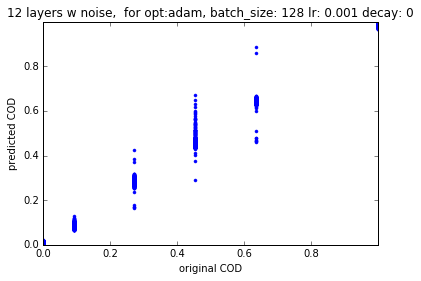

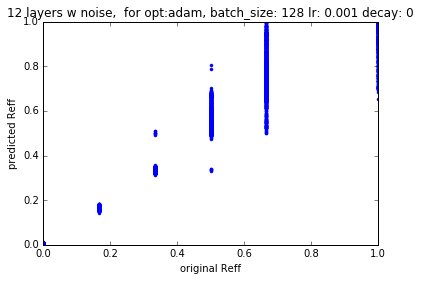

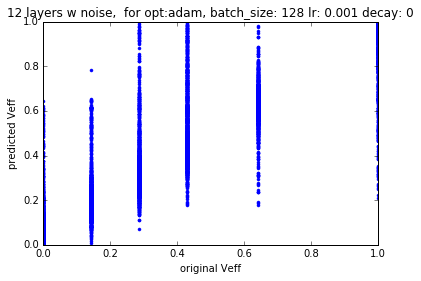

In [149]:
# generate prediction plots
prediction = model.predict(X_test)

vars = ['COD', 'Reff', 'Veff']
# plot prediction per variable

for f in range(len(vars)):
    
    plt.plot(y_test[:,f],prediction[:,f],'.b')
    plt.ylabel('predicted ' + vars[f])
    plt.xlabel('original ' +  vars[f])
    plt.axis([min(y_test[:,f]),max(y_test[:,f]),min(y_test[:,f]),max(y_test[:,f])])
    plotname = "D://ORACLES_NN//py_plots//" + '12 layers w noise for opt adam, ' + " batch_size_" + str(128) + '_' + vars[f] + ".png"
    plt.title('12 layers w noise, ' + " for opt:adam, batch_size: " + str(128) + " lr: " + str(0.001) + " decay: " + str(0))
    plt.savefig(plotname)     
    
    plt.show()


## predict on RSP measurements
##############################################

## 12. this step is to run hyperas hyperparameterization optimization on the best model inputs

In [ ]:
# save model
    #-------------
    model_name = 'KerasFC_image_size_' + str(image_size[im])
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name + '.h5')
    print(model_name, " model saved to disk")
    # load model:
    model_name = 'KerasFC_image_size_' + str(im_size)
    # load json and create model
    json_file = open(model_name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_name + ".h5")
    print("Loaded model from disk")
    model = loaded_model
    
    # predict image line by line
    whole_predict = []
    offstart = 0
    crop_len = int(np.floor(im_size/2))
    num_lines = Transect1_truth.shape[0] - 2*crop_len
    for offset in range(offstart,offstart+num_lines):
        if (offset % 1000 == 0):
            print('Now on step %d ', offset)
        temp_dataset, temp_labelset = load_whole_data(Transect1, Transect1_truth, image_size=im_size, offset = offset, lines=1, toremove=3)
        
        temp_predict = model.predict_on_batch(temp_dataset)
        
        whole_predict.append(classifyback(temp_predict))
        

    whole_predict = np.asarray(whole_predict)
    print(whole_predict.shape)
    
    # calculate accuracy
    #--------------------

    truth_predict = Transect1_truth[crop_len+offstart:crop_len+offstart+num_lines, crop_len:Transect1_truth.shape[1]-crop_len]
    
    y_true = truth_predict.ravel()
    y_pred = whole_predict.ravel()
    
    # overall accuracy
    overall_accuracy = 100*accuracy_score(y_true, y_pred)
    print('Final Accuracy (overall) for image_size %i is %.1f%%' % (im_size,overall_accuracy))
    # weighted accuracy
    w = np.ones(y_true.shape[0])
    for idx, i in enumerate(np.bincount(y_true)):
        w[y_true == idx] *= (i/float(y_true.shape[0]))
    w_accuracy = 100*accuracy_score(y_true, y_pred, sample_weight=w)
    print('Final Accuracy (weighted) %.1f%%' % (w_accuracy))
    # per class accuracy
    num_labels = len(np.unique(truth_predict))
    #0  # Sand
    #1  # Branching
    #2  # Mounding
    #3  # Rock
    class_labels = ('Sand','Branching','Mounding','Rock')
    for i in range(num_labels):
        true = y_true[y_true==i]
        pred = y_pred[y_true==i]
        accuracy = 100*accuracy_score(true, pred)
        print('Accuracy for class %i (%s) is %.1f%%' % (i,class_labels[i], accuracy))
        
    # plot prediction
    #-----------------
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(whole_predict)
    plt.title("prediction")
    # plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(truth_predict)
    plt.title("truth")
    # plt.axis('off')
    plt.show()
    plt_name = "whole_predict_fc_image_size_" + str(im_size) + ".png"
    plt.savefig(plt_name,bbox_inches = 'tight',dpi=1000)
